In [41]:
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm


In [ ]:
class PokerHandAccuracy(_AccuracyMeter):
    def __init__(self):
        self.reset()
        self.confusion = [[0 for y in range(num_classes)] for x in range(num_classes)]

    def reset(self):
        self.num_correct = 0
        self.count = 0
        self.confusion = [[0 for y in range(num_classes)] for x in range(num_classes)]
        
    def accuracy(self): 
        return self.num_correct / self.count

    def update(self, pred, label, log=False):   
        vals, preds = torch.max(actn, 1)
        if log: print("Preds: ", preds)
        _, gt = torch.max(label, 1)     
        if log: print("GT   : ", gt)
        self.num_correct += torch.sum(preds == gt).item()
        if log: print("Num Correct: ", self.num_correct)
        self.count += label.shape[0]
        
        for lab, pred in zip(gt, preds):
            self.confusion[lab][pred] += 1
            
    def plot_confusion_matrix(self,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        cm = np.array(self.confusion)
        fig, ax = plt.subplots(figsize=(12,12))
        img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar(img, ax=ax)
        ax.set_title(title)
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, rotation=45)
        plt.yticks(tick_marks)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

In [19]:
class PokerHandDataset():
    def __init__(self, file):
        self.hands, self.labels = self.parse_csv(file)
       
    @staticmethod
    def parse_csv(file):
        df = pd.read_csv(file, header=None)
        xs = df[df.columns[0:10]]
        ys = df[df.columns[-1]]
        
        labels = np.array([label for label in ys])
        hands = np.array([PokerHandDataset.make_tensor(np.array(hand).reshape((5,2)) - 1) for hand in xs.values])
            
        return hands, ys
        
    @staticmethod
    def make_tensor(hand):
        hand_tensor = np.zeros((4,13)) - 1
        for card in hand: 
            suit = np.zeros(4)
            suit[card[1]] = 1
            hand_tensor[card[0], card[1]] = 1
        return hand_tensor.reshape(-1)
    
    @staticmethod
    def make_one_hot(label):
        tensor = torch.zeros(10)
        tensor[label] = 1
        return tensor
    
    def __len__(self): return len(self.hands)

    def __getitem__(self, i):
        hand, label = self.hands[i], self.labels[i]
        x, y = self.make_tensor(hand), self.make_one_hot(label)
        return x, y

In [20]:
data_path = Path("./Datasets/PokerHands")
train_dataset = PokerHandDataset(data_path/'training.csv')
test_dataset = PokerHandDataset(data_path/'testing.csv')

In [21]:
train_dataset.hands[0]

array([ 1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [34]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(train_dataset.hands)

In [35]:
X_pca = np.array([point for point, lab in zip(X_pca, train_dataset.labels) if lab != 0])
labels = [lab for lab in train_dataset.labels if lab != 0]

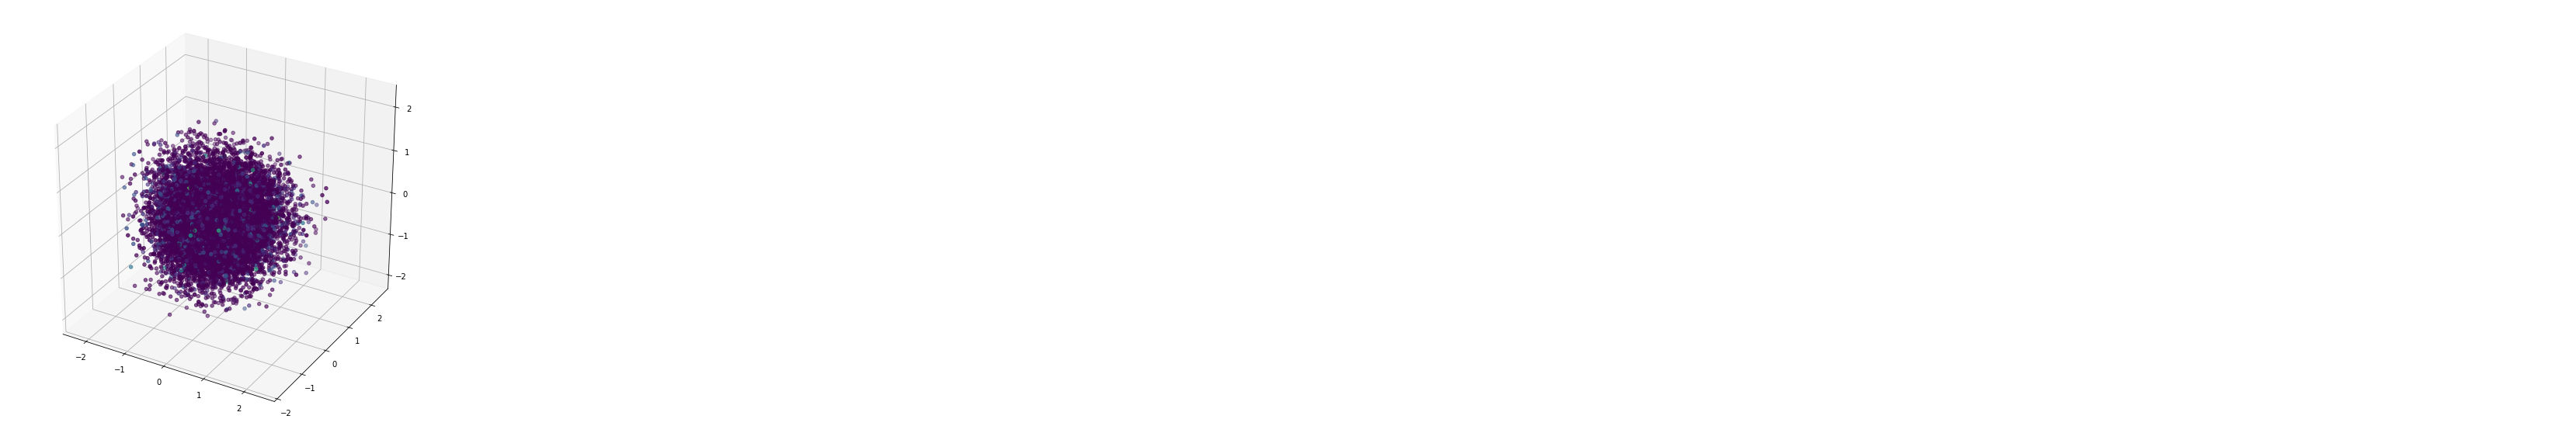

In [40]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the values
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels)

In [ ]:
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(train_dataset.hands, train_dataset.labels)

In [ ]:
accuracy = PokerHandAccuracy()

In [ ]:
clf.predict(test_dataset.hands[0])